In [50]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import rainbow
import os
import glob
from sklearn.decomposition import NMF
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import rainbow
import os
import glob

In [51]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import the jsonified transactions into a dataframe

In [52]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/'
all_files = glob.glob(os.path.join(path, "*.json"))

In [53]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

## Import just one day into a dataframe 

In [54]:
#df=pd.read_json('./jsons/1.json',keep_default_dates=False,lines=True)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73865 entries, 0 to 3052
Data columns (total 10 columns):
date      73865 non-null object
gross+    73865 non-null float64
gross-    73865 non-null float64
items     73865 non-null object
net       73865 non-null float64
oper      73865 non-null int64
term      73865 non-null int64
time      73865 non-null object
trans     73865 non-null int64
type      73865 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 6.2+ MB


DescribeResult(nobs=73865, minmax=(0, 156), mean=11.241575847830502, variance=137.8131609521731, skewness=2.0307334693993537, kurtosis=6.233092545048244)

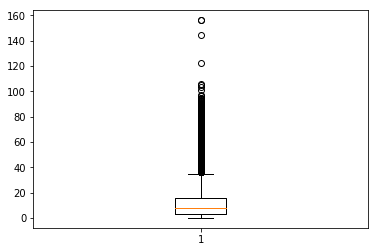

In [69]:
from scipy import stats
basket_counts=[]
for basket in df['items']:
    basket_counts.append(len(basket))
plt.boxplot(basket_counts)
stats.describe(basket_counts)


In [80]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]

In [70]:
df['item_count']=basket_counts

In [83]:
dfq1=df[(df['item_count']>0 )& (df['item_count']<q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<q3)]
dfq4=df[df['item_count']>q3]

In [7]:
df['date']=pd.to_datetime(df['date'],yearfirst=True)

In [8]:
df['day_of_week']=df['date'].dt.day_name()

In [16]:
df['month']=df['date'].dt.month_name()

In [17]:
df = df[df['day_of_week']=='Saturday']

In [18]:
def get_items(df,most_common=10,least_common=5):

    stoppers = ['BAG CREDIT','SF Bag Charge','Gift Card Reload','8 OZ BIO TUB t3', '16OZ BIO TUB t4',
                 '32OZ BIO TUB t5','BOTTLE DEPOSIT','6PACK BEER SMALL C','PAID IN','Gift Card Sale']

    
    '''build a dictionary where the keys are the words
    in the dataframe items column'''
    
    items=[]
    item_dict = defaultdict(int)
    
    for basket in df['items']:
        for item in basket:
            items.append(item[1])
            item_dict[item[1]] += 1
    
    items_set=set(items)

    
    '''add the most common words to the stopwords list'''
    stopwords=list([i[0] for i in Counter(item_dict).most_common(most_common)])
    
    for s in stoppers:
        stopwords.append(s)
        
    '''add items containing "CRV" to the stopwords list'''
    for item in items_set:
        if "crv" in item.lower():
            stopwords.append(item)
    
    '''add the least common words to the stopwords list'''
    for key,value in item_dict.items():
        if value < least_common:
            stopwords.append(key)
    print(type(stopwords) )  
    stopwords = set(stopwords)
    
    '''iterate through the baskets and add items to items_set
    if not in stopwords (too common or too uncommon)'''
    for stops in stopwords:
        items_set.remove(stops)
  

    return items_set,stopwords, item_dict

items_set,stopwords,item_dict = get_items(df,most_common=5,least_common=5)

<class 'list'>


In [19]:
most_common=5
Counter(item_dict).most_common(most_common)

[('BAG CREDIT', 11021),
 ('SF Bag Charge', 2566),
 ('SMALL COOLER CRV', 2291),
 ('BANANAS', 1809),
 ('AVOCADOS HASS', 1396)]

In [20]:
item_matrix = np.zeros((df.shape[0],len(items_set)))

In [21]:
df_items= pd.DataFrame(item_matrix,columns=items_set)

In [22]:
df_items[df_items==500]

,MANDERINE GOLD NU,6329 MEDM BROWN RI,3685 WW BREAD FLOU,KEVITA MB PINE,BRAGGS CIDER VINEG,SLICED CUP CRIM,6296 WLD RICE BLND,UNCREAMERY TRUF BR,Earth Science Scru,3650 SEMOLINA,...,8320LAPSANG SOUCHO,SIGGIS PLAIN 24OZ,BTTRMLK QT CLOVER,SIETE NO SALT,5665MCY EVOLIVE OI,FLAX MILK ORIG,GRILL SPONGE,GRANNY BAG,5165 CURRY CASHEWS,GREEN VALLEY CC
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df.index

Int64Index([2534, 2546,    0,    1,    2,    3,    4,    5,    6,    7,
            ...
            3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051],
           dtype='int64', length=12144)

In [24]:
df=df.reset_index()

In [25]:
df.index

RangeIndex(start=0, stop=12144, step=1)

In [26]:
df.describe()

,index,gross+,gross-,net,oper,term,trans
count,12144.000000,12144.000000,12144.000000,12144.000000,12144.000000,12144.000000,12144.000000
mean,1517.538702,137.364165,5.343006,132.021159,123.761775,4.985096,157.770751
std,876.572010,563.567642,122.471132,532.169491,326.308725,2.922315,105.431944
min,0.000000,0.000000,0.000000,-521.080000,4.000000,1.000000,1.000000
25%,758.750000,16.820000,0.000000,16.287500,41.000000,2.000000,69.750000
50%,1517.500000,47.100000,0.000000,46.285000,64.000000,5.000000,144.000000
75%,2276.250000,103.577500,0.000000,102.007500,81.000000,7.000000,234.000000
max,3084.000000,13715.100000,7163.170000,12453.200000,1745.000000,11.000000,502.000000


In [27]:
df.pop('index')
print ()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12144 entries, 0 to 12143
Data columns (total 12 columns):
date           12144 non-null datetime64[ns]
gross+         12144 non-null float64
gross-         12144 non-null float64
items          12144 non-null object
net            12144 non-null float64
oper           12144 non-null int64
term           12144 non-null int64
time           12144 non-null object
trans          12144 non-null int64
type           12144 non-null object
day_of_week    12144 non-null object
month          12144 non-null object
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 1.1+ MB


In [29]:
df.iloc[:,0].index


RangeIndex(start=0, stop=12144, step=1)

In [30]:
df_items.iloc[:,0].index

RangeIndex(start=0, stop=12144, step=1)

In [31]:
col_index_dict = dict(zip(items_set, range(len(items_set))))

In [32]:
matrix = np.zeros(df_items.shape)
matrix.shape

(12144, 5163)

In [33]:
#iterate through all rows and insert value of item at row of basket and column of item
for i in range(df.shape[0]):
    for item in df['items'][i]:
        #print( item )
        #print( i, col_index_dict[ item[1] ], item[2] )
        #set item matrix to boolean:
        #matrix[i,col_index_dict[ item[1] ]] = 1
        if item[1] not in stopwords:
            matrix[i,col_index_dict[ item[1] ]] = matrix[i,col_index_dict[ item[1] ]] + item[2]
        #df.iat[i,col_index_dict[ item[1] ]] = df.iloc[i,col_index_dict[ item[1] ]] + item[2]
        #print(item[2])
        #print(i)
        #print()

In [34]:
matrix.shape

(12144, 5163)

In [35]:
matrix.shape[0]*matrix.shape[1]

62699472

In [36]:
matrix[matrix<0]=0

In [37]:
spare_matrix = matrix.copy()

In [38]:
np.log10(55.99)

1.7481104674949839

In [40]:
matrix.max()


500.0

In [45]:
matrix=np.log10(matrix)

In [39]:
sparse_matrix = sparse.csr_matrix(matrix)

In [40]:
sparse_matrix

<12144x5163 sparse matrix of type '<class 'numpy.float64'>'
	with 95754 stored elements in Compressed Sparse Row format>

In [41]:
529061/982109040

0.0005386988393875287

In [42]:
from sklearn.decomposition import NMF

In [43]:
def fit_model(sparse_matrix,n_components=10,max_iter=200):

    model = NMF(n_components=n_components,max_iter=200)
    W = model.fit_transform(sparse_matrix)
    H = model.components_
    return model,W,H

In [44]:
model,W,H = fit_model(sparse_matrix,n_components=2,max_iter=200)
model.n_iter_

16

In [45]:
feature_names=list(items_set).copy()
n_top_words=250
for topic in H:
    print(topic.argsort()[:-n_top_words - 1:-1])
    print ([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])
    print()

[4184 2128 2320 2913 4692 1979 3526 2506 1811 2322 1529 2597 4065 3489
  841 4286 4703 2555 5085 1372 1609 4629 1709 2528 3336 3710 2741 4438
 4757 2621  432 4016 3409 4722 4661  320 2077 2945 2775 2186 1932 3654
 2026 2711 4357 2044 2201 1111  327 3269 3220 1544  258 2517  848 3106
 4868 1165 4121  167 4795  256 2662  931 1952 2929 2903 1603 1735 3038
 3810 2783  676 2142  317 2622 1443 4322 4254 4838  686 3824 3908  699
 4510  514 1576 4235 2301 2598 1268 1693 4124 1794 3818  235 4139  691
  773 3754 3448 4066 2603 1078 3627 1198 4886 1658 1427  906  339  193
 1838 3160 3318 4562 2628 3411 3258 4637 2797  857 4981 3127 3743 3646
 2287  952 2160 2971 1008 4155 4141 3848 4719 4646 4543 1877 1375 2381
 2885  568 5144  255 3242 4268 3895  870 2541 1292  827  362 2481 1944
 1918 1908 3047 4659 1021 2028 2483 3979 1882 3655 5061  221 2203 3665
 1650 1696   16 2911 4402 3701 3199  652 1954 4275  635 2653 4965 2808
 4006 2712 1623 3589 2090 4772 3435  983 1540 4265 2919  908 3761 3651
 3837 

In [43]:
H.max()

81.74845215357924

In [44]:
H[:,1].argsort()[-10:][::-1]

array([5, 8, 3, 9, 7, 6, 4, 2, 1, 0])

In [45]:
model

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=10, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [46]:
len(list(items_set))

21461

Topic #0:
['NN Algae120vgel', 'Hf VitaMinGreen500', 'CELERY', 'INDONESIAN TEMPEH', '2195 ORG GARBANZO', 'NN Ultimate Omega1', '2268 CORN CHOWDER', '2215 ORGANIC LENTI', 'RED MISO', 'SFM COCOALMND MLK']


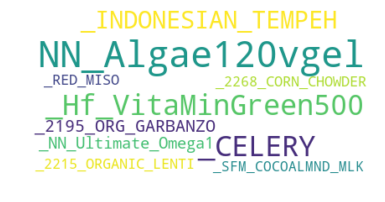

Topic #1:
['APPLES FUJI', '5120 ORG ALMONDS', '5290 WALNUTS', 'BLUEBERRIES', '5250 ORG PECAN HA', 'CELERY', 'ARTICHOKES', 'ORANGES NAVEL', 'SATSUMA MANDARIN', '5180 WHOLE CASHEWS']


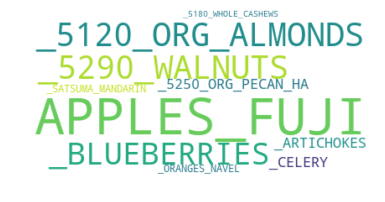

In [46]:
def print_top_items(model, feature_names, n_top_words):
    topics =[]
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

        topics.append(topic_string)
        print(topic_string)
        #print()
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(topic_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)
print_top_items(model,list(items_set),10)

In [47]:
df['items'][1116]

[['', 'CRV LRG SING T', 0.1, 15],
 ['', 'SMALL COOLER CRV', 0.05, 13],
 ['', 'SMALL COOLER CRV', 0.05, 13],
 ['', 'BAKERY', 2.25, 17],
 ['MP', 'Worker 20% PkgFood', -0.26, 15],
 ['MP', 'Worker 20% Refrig', -1.2, 13],
 ['MP', 'Worker 20% Bakery', -0.45, 17]]

In [48]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print(df['time'][basket_id],"item:",items)
    #return basket
#print_basket_contents(1116)

In [49]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,10)

++++++++++++++++++Topic #0, basket #1+++++++++++++++++++
14:54 item: ['', 'RED MISO', 9.29, 13]
14:54 item: ['', 'KEVITA TURM TONIC', 2.29, 13]
14:54 item: ['', 'SMALL REF CRV TAX', 0.05, 13]
14:54 item: ['', 'KEVITA TURM TONIC', 2.29, 13]
14:54 item: ['', 'SMALL REF CRV TAX', 0.05, 13]
14:54 item: ['', 'Hf VitaMinGreen500', 59.95, 2]
14:54 item: ['', 'SMALL REF CRV TAX', 0.05, 13]
14:54 item: ['', 'BIO STRAINED TOMAT', 2.99, 15]
14:54 item: ['', 'BIO STRAINED TOMAT', 2.99, 15]
14:54 item: ['', 'NN Algae120vgel', 41.56, 1]
14:54 item: ['', 'NN Algae120vgel', 41.56, 1]
14:54 item: ['', 'NN Algae120vgel', 41.56, 1]
14:54 item: ['', 'NN Algae120vgel', 41.56, 1]
14:54 item: ['', 'NN Algae120vgel', 41.56, 1]
14:54 item: ['', 'Coldcalm kids 30d', 12.79, 1]
14:54 item: ['', 'NN Algae120vgel', 41.56, 1]
14:54 item: ['', 'Coldcalm kids 30d', 12.79, 1]
14:54 item: ['', 'BO Camilia 30dose', 12.65, 1]
14:54 item: ['', 'ORG GING GAR PASTE', 5.49, 15]
14:54 item: ['', 'EDEN GARBANZOS', 2.39, 15]
14:

In [71]:
W[:,1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.90617938e-06, 2.20951407e-06, 0.00000000e+00])

In [74]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

0 [2484 2136  206 1022 2130 1465  456  168  272  144]
1 [ 116 1239 1090  326 1093 1938 1919 2311 1273 2116]
2 [1159 1189  383  722 1864 1368 1391 1136  537  314]
3 [2134 2142 2132 1946 1326 1491 2256  798 1593 1994]
4 [ 209  202 2481 2486 1566  289 2207 1272  307  793]
5 [2400  447 1231 1804 2372 1210  817  808  688 2081]
6 [ 911 1696 1927 1086 1285  131 1265 1322  700  672]
7 [2278 2094 2129 2133 2236 2242 2089 2454  161 2481]
8 [ 422 1025 1018  735  447 1589 2129 2133 1698  237]
9 [ 525  238  239 1284 2454  115 2396 2150 1942 1559]


In [76]:
len(list(items_set))

6576

In [75]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

[1752 6585 2198 2188 2189 2190 2191 2192 2193 2194]
[1271 6539 4820   80 4966 1929 2604 6546 2660 4806]
[6114 3455  640 2958  537   84 2189 4025 1017 4051]
[3058 2646 2476 5751 5768 6309 4302 4243 3450 6388]
[1484 4994 5017  125 4381  102 1207  435 1811 4079]


In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [72]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

4112 SINTO KIMCHI 13.54
PEPPERS RED BELL 2.75
CUCUMBERS 12.73
ORGANIC 2LB TOFU 20.95
5540 TAHINI 12.17
GINGER 4.79
GARLIC WHITE 3.01
PRODUCE SCALE 1.79
LIMES 2.0
CILANTRO 1.99
CILANTRO 1.99
BROCCOLI LOOSE 6.24
CELLO CAULIFLOWER 11.96
LEEKS 9.12
SUGAR PLUM CLAM 5.97
BEETS RED LOOSE 6.01
store 100% Bulks -34.5
store 100% Produce -70.35
store 100% Refrig -20.95


In [12]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
df['CILANTRO'][10:11]

10    3.98
Name: CILANTRO, dtype: float64

In [19]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
df.shape

(2535, 6586)

In [22]:
df.to_pickle('02012019.pkl')

In [213]:
len(items_set)

6576

In [114]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]


In [96]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]
[[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]]


In [4]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [80]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

['', 'BLUEBERRIES', 5.99, 12]
1 
2 BLUEBERRIES
3 5.99
4 12
['', 'ALXNDRE YOGURT', 4.99, 13]
5 
6 ALXNDRE YOGURT
7 4.99
8 13
['MP', 'Worker 20% Produce', -1.2, 12]
9 MP
10 Worker 20% Produce
11 -1.2
12 12
['MP', 'Worker 20% Refrig', -1.0, 13]
13 MP
14 Worker 20% Refrig
15 -1.0
16 13


NameError: name 'plt' is not defined

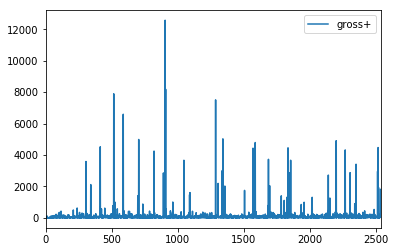

In [51]:
df[['gross+','time']].plot()
plt.show()

In [33]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

yep


In [18]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


f: ('./tlogs', ['201902'], ['.DS_Store']) sub: []
f: ('./tlogs/201902', ['20190202', '20190203', '20190204', '20190205', '20190206', '20190207', '20190208', '20190209', '20190210', '20190211', '20190212', '20190213', '20190214', '20190215', '20190216', '20190217', '20190218', '20190219', '20190220', '20190221', '20190222', '20190223', '20190224', '20190225', '20190226', '20190227', '20190228', '20190301'], ['.DS_Store']) sub: []
f: ('./tlogs/201902/20190202', [], ['checklisting.txt', 'department.txt', 'Department01Discounts.txt', 'Department04Discounts.txt', 'Department06Discounts.txt', 'Department07Discounts.txt', 'Department08Discounts.txt', 'Department09Discounts.txt', 'Department10Discounts.txt', 'Department11Discounts.txt', 'Department12Discounts.txt', 'Department13Discounts.txt', 'Department14Discounts.txt', 'Department15Discounts.txt', 'Department16Discounts.txt', 'Department17Discounts.txt', 'Department19Discounts.txt', 'Department26Discounts.txt', 'dept.txt', 'discountitems.tx

In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [8]:
df=pd.read_pickle('02012019.pkl')

In [10]:
df[df['BANANAS']!=0]

,date,gross+,gross-,items,net,oper,term,time,trans,type,...,PRO BAR MINT CHOC,8213 FENNEL POWDER,OR Cooked Beets,JR Melatonin SR 12,NUT WALNUT,QT Elderbry Loz 36,SW WB Vanilla 12pk,6556 DUTCH COCOA,lvngClyBntonte 8oz,CARDAMOM BITTERS
36,2001-02-19,37.65,0.00,"[[, PASCHA UNSWT CCHIP, 4.99, 15], [, PRIMAVER...",37.65,104,5,09:16,8,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2001-02-19,108.17,0.00,"[[, FORGER PL CSH YOG, 5.59, 13], [, SO DEL UN...",108.17,42,6,09:20,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,2001-02-19,20.72,0.00,"[[, APPLES FUJI, 2.42, 12], [, 8308KEEMUN BLAC...",20.72,11,1,09:27,7,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,2001-02-19,144.42,0.00,"[[, WOODSTK BLUEBERRIE, 6.29, 19], [, EVOLUTIO...",144.42,42,6,09:30,17,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,2001-02-19,17.69,0.00,"[[, COELA ZIPPER TOTE, 9.99, 6], [, BANANAS, 2...",17.69,42,6,09:31,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,2001-02-19,224.03,0.00,"[[, APPLE JUICE, 11.39, 15], [, ORG GAL CLOVER...",224.03,104,5,09:32,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,2001-02-19,80.01,0.00,"[[, MAC HAWAI SEA SALT, 7.99, 15], [, UMLAUT C...",80.01,42,6,09:35,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,2001-02-19,86.51,0.00,"[[, FLAVORG VANILLA4oz, 15.49, 15], [, SUGAR P...",86.51,34,8,09:39,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,2001-02-19,285.53,0.00,"[[, VH Kids Vibe Choc, 34.4, 1], [, EZ Ultimat...",285.53,11,1,09:40,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,2001-02-19,55.73,0.00,"[[, QRT CAN JAR t101, 1.79, 6], [, QRT CAN JAR...",55.73,42,6,09:41,25,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
